# Содержание

* [1 Подготовка данных](#1-Подготовка-данных)
    - [1.1 Загрузка данных](#1.1-Загрузка-данных)
    - [1.2 Обработка целевого признака](#1.2-Обработка-целевого-признака)
    - [1.3 Разделение на выборки](#1.3-Разделение-на-выборки)
    - [1.4 Кодирование данных](#1.4-Кодирование-данных)
* [2 Обучение модели](#2-Обучение-модели)
    - [2.1 ML](#2.1-ML)
        - [2.1.1 LogisticRegression (Baseline)](#2.1.1-LogisticRegression-(Baseline))
        - [2.1.2 KNeighborsClassifier](#2.1.2-KNeighborsClassifier)
        - [2.1.3 MLPClassifier](#2.1.3-MLPClassifier)
    - [2.2 DL](#2.2-DL)
    - [2.3 Выбор модели](#2.3-Выбор-модели)
* [3 Тестирование модели](#3-Тестирование-модели)
* [4 Экспорт модели](#4-Экспорт-модели)
* [5 Общий вывод](#5-Общий-вывод)

# Этап 2. Подбор модели

**Задача:** Подбор модели для задачи Multi-label classification.

**Источник данных:** `/data/preprocessed_data/data_train`, `/data/preprocessed_data/data_test`.

**Характер данных:** наименования блюд и названию кухонь.

---

## 1 Подготовка данных

### 1.1 Загрузка данных

Установка библиотек:

In [1]:
%%capture no-display
!pip install scikit-multilearn pickle

Импорт библиотек:

In [71]:
import pandas as pd
import numpy as np

import os
import datetime
import time

import pickle
import joblib

from typing import Tuple, List, Dict
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, Sequential, layers, optimizers, regularizers
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

Игнорирование предупреждений:

In [3]:
import warnings

warnings.filterwarnings('ignore')

Фисксирование случайных величин:

In [4]:
SEED = 42

tf.random.set_seed(SEED)

Задание пути до папки с данными:

In [5]:
PATH = 'data/preprocessed_data/'

Выведение на экран содержимого папки с данными:

In [6]:
os.listdir(PATH)

['data_test.csv',
 'data_test_cuisine.csv',
 'data_train.csv',
 'data_train_cuisine.csv']

Загрузка данных:

In [7]:
join_path = lambda x: os.path.join(PATH, x)

data_train = pd.read_csv(join_path('data_train_cuisine.csv'), index_col=0)
data_test = pd.read_csv(join_path('data_test_cuisine.csv'), index_col=0)

Выведение на экран первых строк набора данных:

In [8]:
data_train.head(3)

,name,multilabels
0,chicken cutlet with rice,"western, singaporean, chicken, chinese, fried ..."
1,chicken chop,"western, chicken, indian, fried chicken, chine..."
2,chicken wings with rice,"western, chicken, asian"


>**Вывод**
>
>* Перед обучением модели признаки необходимо привести к числовому виду.

---

### 1.2 Обработка целевого признака

Выведение на экран общего количества уникальных классов:

In [9]:
print('Total labels:', len(set(', '.join(data_train['multilabels']).split(', '))))

Total labels: 78


Преобразование строк с классами в списки:

In [10]:
split_labels = lambda x: x['multilabels'].str.split(', ')

data_train['multilabels'] = split_labels(data_train)
data_test['multilabels'] = split_labels(data_test)

Выведение на экран первых строк набора данных для проверки применённых изменений:

In [11]:
data_train.head(3)

,name,multilabels
0,chicken cutlet with rice,"[western, singaporean, chicken, chinese, fried..."
1,chicken chop,"[western, chicken, indian, fried chicken, chin..."
2,chicken wings with rice,"[western, chicken, asian]"


>* Поскольку целевой признак представляет собой множество классов, которые соответствуют одному входному значению, разрабатываемая модель должна решать задачу Multi-label classification.
>
>* Для обучения модели необходимо обработать целевой признак таким образом, чтобы сформировать вектор, длиной в уникальное количество элементов среди предсказываемых классов, все значения в котором 0 за исключением тех, что пересекаются с соответсвующими объекту классами, значения которых будут представлены в виде 1 (по принципу работы OneHotEncoding).

Объявление объекта кодирования:

In [12]:
multilabel = MultiLabelBinarizer()

Обучение объекта кодирования:

In [13]:
multilabel.fit(data_train['multilabels'])

MultiLabelBinarizer()

Кодирование классов целевого признака:

In [14]:
join_multilabel = lambda x: x.join(
    pd.DataFrame(
        multilabel.transform(x['multilabels']),
        columns=multilabel.classes_
    )
)

data_train = join_multilabel(data_train)
data_test = join_multilabel(data_test)

Выведение на экран первых строк набора данных для проверки применённых изменений:

In [15]:
data_train.head(1)

,name,multilabels,acai bowl,american,asian,ayam penyet,bak kut teh,bakery,ban mian,beverages,...,spanish,sushi,tea,thai,turkish,vegetarian,vietnamese,western,wraps,yong tau foo
0,chicken cutlet with rice,"[western, singaporean, chicken, chinese, fried...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


>**Вывод**
>
>* Данные необходимо разделить на выборки.

---

### 1.3 Разделение на выборки

Перемешивание обучающего набора данных:

In [16]:
data_train_shuffle = data_train.sample(frac=1, random_state=SEED)

Разделение наборов данных на обучающие признаки и целевые признаки:

In [17]:
get_y = lambda x: np.array(x[x.columns[2:]])

X_train = data_train['name'].to_numpy()
y_train = get_y(data_train)

X_test = data_test['name'].to_numpy()
y_test = get_y(data_test)

Разделение обучающей выборки на обучающую и валидационную:

In [18]:
X_train_vect, X_val_vect, \
y_train_vect, y_val_vect = train_test_split(X_train.copy(), y_train.copy(), test_size=0.25)

Задание нескольких примеров для демонстрации работы моделей:

In [19]:
X_val = X_test[-5:]
y_val = y_test[-5:]

Выведение на экран размеров выборок:

In [20]:
print(
    'ML models',
    'X_train shape:', X_train.shape,
    '\nX_test shape:', X_test.shape
)

print(
    '\nDL networks',
    '\nX_train_vect shape:', X_train_vect.shape,
    '\nX_vel_vect shape:', X_val_vect.shape,
    '\nX_test shape:', X_test.shape
)

ML models X_train shape: (67739,) 
X_test shape: (43625,)

DL networks 
X_train_vect shape: (50804,) 
X_vel_vect shape: (16935,) 
X_test shape: (43625,)


>**Вывод**
>
>* Далее необходимо закодировать значения столбца признаков, чтобы подавать в модель корректные входные значения.

---

### 1.4 Кодирование данных

Задание функции, трансформирующей многоклассовую последовательность в слова:

In [21]:
def transform_label(label: int, vocab) -> List[Tuple[str]]:
    '''Convert label to word.

    Args:
      - label (int) - label
      - vocab - vocabulatory
    '''

    return vocab.inverse_transform(np.array([label]))

---

Выведение на экран образца объекта с кодированием и раскодированием его целевого признака:

In [22]:
print(
    'meal:', X_train[0],
    '\n\ncuisine label:\n', y_train[0],
    '\n\ncuisine:', transform_label(y_train[0], multilabel)
)

meal: chicken cutlet with rice 

cuisine label:
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0] 

cuisine: [('chicken', 'chinese', 'fried chicken', 'pasta', 'seafood', 'singaporean', 'western')]


---

**TfidfVectorizer**

Выведение на экран числовых характеристик обучающей выборки:

In [23]:
round(pd.Series(X_train).str.len().describe(), 1)

count    67739.0
mean        21.6
std          8.4
min          3.0
25%         15.0
50%         21.0
75%         27.0
max         60.0
dtype: float64

Задание констант:

In [24]:
n_labels = len(multilabel.classes_)

max_vocab_len = len(set(' '.join(list(X_train)).split()))
max_out_len = round(pd.Series(X_train).str.len().sum() / X_train.shape[0])

print('Total labels:', n_labels)
print('\nMaximum vocabulatory length:', max_vocab_len)
print('Maximum output length:', max_out_len)

Total labels: 78

Maximum vocabulatory length: 10886
Maximum output length: 22


Задание объекта векторизации:

In [25]:
vectorizer_tfidf = TfidfVectorizer(
    max_features=max_vocab_len,
    analyzer='word',
    ngram_range=(1, 2),
    stop_words='english'
)

---

**layers.TextVectorization**

Задание слоя векторизации:

In [26]:
vectorizer_text_tfidf = layers.TextVectorization(
    max_tokens=max_vocab_len,
    ngrams=2,
    output_mode='tf_idf'
)

Обучение объекта векторизации:

In [27]:
with tf.device('/CPU:0'):
    vectorizer_text_tfidf.adapt(X_train)

Трансформация выборок:

In [28]:
with tf.device('/CPU:0'):
    X_train_vect = vectorizer_text_tfidf(X_train_vect)
    X_val_vect = vectorizer_text_tfidf(X_val_vect)
    X_val_vect_2 = vectorizer_text_tfidf(X_val)
    X_test_vect = vectorizer_text_tfidf(X_test)

>**Вывод**
>
>* Данные были подготовлены к обучению на них модели.

---

## 2 Обучение модели

Задание функции, трансформирующей вероятности классов в классы:

In [29]:
def transform_probs_to_labels(probs: np.ndarray, threshold: float = 0.5) -> List[int]:
    '''Convert probabilities to labels.

    Args:
      - probs (np.ndarray) - probabilities
      - threshold (int, optional) - threshold to convert values
    '''

    return (probs > threshold).astype(int)

Задание функции, выводящей таблицу для сравнения предсказаний с ответами:

In [30]:
def compare_pred_true(X: pd.Series or np.ndarray,
                      y: np.ndarray,
                      preds: List[Tuple[str]],
                      limit: int = 5) -> None:

    '''Display table comparing in columns predictions and true classes.

    Args:
      - X (pd.Series or np.ndarray) - train features values
      - y (np.ndarray) - target feature values
      - preds (List[Tuple[str]]) - predictions
      - limit (int, optional) - number of rows. Defaults to 5
    '''

    df = []

    for i in range(limit):
        label_pred = transform_label(preds[i], multilabel)
        label_true = transform_label(y[i], multilabel)

        df.append([X[i], label_pred, label_true])

    display(pd.DataFrame(df, columns=['name', 'prediction', 'true']))

Задание функции, строящей графики метрики и функции потерь:

In [31]:
def plot_history(history, score_name: str) -> None:
    '''Plot chart with train and val loss and score values.

    Args:
      - history - history of FCNN model training
      - score_name (str) - name of score in history
    '''

    accuracy_train = history.history[score_name]
    accuracy_val = history.history[f'val_{score_name}']

    loss_train = history.history['loss']
    loss_val = history.history['val_loss']

    x = range(len(accuracy_train))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy_train, 'b', label=f'train')
    plt.plot(x, accuracy_val, 'r', label=f'valid')
    plt.title(f'{score_name.capitalize()}\n')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss_train, 'b', label='train')
    plt.plot(x, loss_val, 'r', label='valid')
    plt.title('Loss\n')
    plt.legend()

    plt.show()

Задание функции, вычисляющей метрики:

In [32]:
def save_values(name: str, model,
                params: Dict,
                score: float,
                mean_time: float,
                save_to: pd.DataFrame,
                show_table: bool = True) -> None:

    '''Save best model values.

    Args:
      - name (str) - estimator name
      - model - best estimator
      - params (Dict) - best search parameters
      - score (float) - best score
      - mean_time (float) - mean time of estimator fit
      - save_to (pd.DataFrame) - dataframe to save scores
      - display (bool) - display or not the results
    '''

    save_to.loc[name, 'model'] = model
    save_to.loc[name, 'params'] = [params]
    save_to.loc[name, 'score'] = round(score, 2)
    save_to.loc[name, 'mean_fit_time'] = round(mean_time, 2)
    
    if show_table:
        display(pd.DataFrame(save_to.loc[name]).T[['score', 'mean_fit_time']])
    else:
        print('Score:', score)

Задание функции обучения модели:

In [33]:
def train_model(model,
                X: pd.Series or np.ndarray,
                y: np.ndarray,
                params: Dict,
                name: str,
                save_to: pd.DataFrame,
                scoring: str or List[str] = 'accuracy',
                cv: int = 3,
                grid_search: bool = False) -> None:

    '''Train model.

    Args:
      - model - estmator
      - X (pd.Series or np.ndarray) - train features values
      - y (np.ndarray) - target feature values
      - params (Dict, optional) - search parameters
      - name (str) - estimator name
      - save_to (pd.DataFrame) - dataframe to save scores
      - scoring (str or List[str], optional) - metric to score model. Defaults to accuracy
      - cv (int, optional) - cross-validation folds. Defaults to 3
      - grid_search (bool, optional)
    '''

    time_start = time.time()

    print('Searching...')

    search_params = {
        'estimator': model,
        'scoring': scoring,
        'refit': True if type(scoring) is str else 'accuracy',
        'cv': cv,
        'verbose': 0,
        'n_jobs': -1
    }

    if grid_search is False:
        if len(params) > 3:
            search = RandomizedSearchCV(**search_params, param_distributions=params)
        else:
            search = GridSearchCV(**search_params, param_grid=params)

    search.fit(X, y)

    # best results
    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = best_model.score(X, y)

    best_results = pd.DataFrame(search.cv_results_).loc[search.best_index_]
    mean_time = best_results['mean_fit_time']

    print('Finished')
    print('\nEstimated search time:', round((time.time() - time_start) / 60, 2), 'min')

    save_values(name, best_model, best_params, best_score, mean_time, save_to)

---

Объявление переменной, которая будет хранить результаты вычисления метрик моделей:

In [34]:
results = pd.DataFrame()

<br>

Свойство | Значение
-|-
Признаки | `name`
Кодирование признаков | 1) ML - TfidfVectorizer<br>2) DL - tf.keras.layers.TextVectorization
Целевой признак | `primary_cuisine`
Кодирование целевого признака | MultiLabelBinarizer
Метрики | `accuracy`
Функция потерь | `binary_crossentropy`
Порог | 0.6
Baseline ML | OneVsRestClassifier + LogisticRegression
DL модель | FCNN

---

### 2.1 ML

#### 2.1.1 LogisticRegression (Baseline)

Объявление пайплайна обучения модели:

In [35]:
pipeline_0 = Pipeline([
    ('tfidf', vectorizer_tfidf),
    ('model', OneVsRestClassifier(LogisticRegression()))
])

Задание параметров модели:

In [36]:
params_0 = {
    'model__estimator__multi_class': ['ovr'],
    'model__estimator__n_jobs': [-1],
    'model__estimator__random_state': [SEED]
}

Обучение модели:

In [37]:
train_model(
    pipeline_0,
    X_train,
    y_train,
    params=params_0,
    name='log_reg',
    save_to=results
)

Searching...
Finished

Estimated search time: 2.1 min


,score,mean_fit_time
log_reg,0.23,16.81


Выведение на экран сравнения предсказаний с целевыми значениями:

In [38]:
compare_pred_true(
    X=X_val,
    y=y_val,
    preds=results.loc['log_reg', 'model'].predict(X_val)
)

,name,prediction,true
0,chilli sauce rice cake,[()],"[(korean,)]"
1,seafood spring onion pancake,[()],"[(korean,)]"
2,ginger lessi smoothie,[()],"[(turkish,)]"
3,bakkwa spring roll,[()],"[(chinese,)]"
4,matcha milk tea large,"[(bubble tea,)]","[(bubble tea,)]"


---

#### 2.1.2 KNeighborsClassifier

Объявление пайплайна обучения модели:

In [39]:
pipeline_1 = Pipeline([
    ('tfidf', vectorizer_tfidf),
    ('model', KNeighborsClassifier())
])

Задание параметров модели:

In [40]:
params_1 = {
    'model__n_neighbors': [5], #range(5, 11),
    'model__algorithm': ['ball_tree'], #['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': [34], #range(20, 41),
    'model__n_jobs': [-1]
}

Обучение модели:

In [41]:
train_model(
    pipeline_1,
    X_train,
    y_train,
    params=params_1,
    name='kn_class',
    save_to=results
)

Searching...
Finished

Estimated search time: 3.36 min


,score,mean_fit_time
kn_class,0.41,0.73


Выведение на экран сравнения предсказаний с целевыми значениями:

In [42]:
compare_pred_true(
    X=X_val,
    y=y_val,
    preds=results.loc['kn_class', 'model'].predict(X_val)
)

,name,prediction,true
0,chilli sauce rice cake,"[(chinese, korean)]","[(korean,)]"
1,seafood spring onion pancake,[()],"[(korean,)]"
2,ginger lessi smoothie,[()],"[(turkish,)]"
3,bakkwa spring roll,"[(chinese,)]","[(chinese,)]"
4,matcha milk tea large,"[(bubble tea,)]","[(bubble tea,)]"


---

#### 2.1.3 MLPClassifier

In [43]:
pipeline_3 = Pipeline([
    ('tfidf', vectorizer_tfidf),
    ('model', MLPClassifier())
])

Задание параметров модели:

In [46]:
params_3 = {
    'model__hidden_layer_sizes': [(150, 100, 50)], #[(150, 100, 50), (120, 80, 40), (100, 50, 30)],
    'model__activation': ['relu'],
    'model__solver': ['adam'],
    # 'model__learning_rate': ['constant','adaptive'],
    'model__random_state': [SEED]
}

Обучение модели:

In [47]:
train_model(
    pipeline_3,
    X_train,
    y_train,
    params=params_3,
    name='mlp_class',
    save_to=results
)

Searching...
Finished

Estimated search time: 194.55 min


,score,mean_fit_time
mlp_class,0.9,5767.7


Выведение на экран сравнения предсказаний с целевыми значениями:

In [48]:
compare_pred_true(
    X=X_val,
    y=y_val,
    preds=results.loc['mlp_class', 'model'].predict(X_val)
)

,name,prediction,true
0,chilli sauce rice cake,"[(korean,)]","[(korean,)]"
1,seafood spring onion pancake,"[(korean,)]","[(korean,)]"
2,ginger lessi smoothie,"[(beverages, bubble tea)]","[(turkish,)]"
3,bakkwa spring roll,"[(chinese,)]","[(chinese,)]"
4,matcha milk tea large,"[(bubble tea,)]","[(bubble tea,)]"


---

### 2.2 DL

Объявление модели:

In [49]:
model_4 = Sequential([
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.L2(l2=1e-3),
                 bias_regularizer=regularizers.L2(l2=1e-3)),

    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(n_labels, activation='sigmoid')
])

model_4.build(X_train_vect.shape)
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (50804, 256)              2787072   
                                                                 
 dense_1 (Dense)             (50804, 128)              32896     
                                                                 
 dense_2 (Dense)             (50804, 64)               8256      
                                                                 
 batch_normalization (BatchN  (50804, 64)              256       
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (50804, 78)               5070      
                                                                 
Total params: 2,833,550
Trainable params: 2,833,422
Non-trainable params: 128
____________________________________________

Настройка модели:

In [50]:
model_4.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)

Обучение модели:

In [51]:
history_4 = model_4.fit(
    X_train_vect,
    y_train_vect,
    validation_data=(X_val_vect, y_val_vect),
    epochs=20,
    batch_size=128
)

Epoch 1/20
397/397 [==============================] - 8s 15ms/step - loss: 0.2456 - accuracy: 0.2498 - val_loss: 0.0836 - val_accuracy: 0.3191
Epoch 2/20
397/397 [==============================] - 5s 13ms/step - loss: 0.0773 - accuracy: 0.3623 - val_loss: 0.0780 - val_accuracy: 0.3764
Epoch 3/20
397/397 [==============================] - 5s 12ms/step - loss: 0.0749 - accuracy: 0.3909 - val_loss: 0.0750 - val_accuracy: 0.3908
Epoch 4/20
397/397 [==============================] - 5s 11ms/step - loss: 0.0730 - accuracy: 0.4078 - val_loss: 0.0737 - val_accuracy: 0.4005
Epoch 5/20
397/397 [==============================] - 5s 11ms/step - loss: 0.0715 - accuracy: 0.4173 - val_loss: 0.0720 - val_accuracy: 0.4107
Epoch 6/20
397/397 [==============================] - 5s 11ms/step - loss: 0.0705 - accuracy: 0.4256 - val_loss: 0.0728 - val_accuracy: 0.4210
Epoch 7/20
397/397 [==============================] - 5s 11ms/step - loss: 0.0696 - accuracy: 0.4299 - val_loss: 0.0720 - val_accuracy: 0.4175

Выведение на экран графиков функции потерь и метрики модели на обучающей и валидационной выборках:

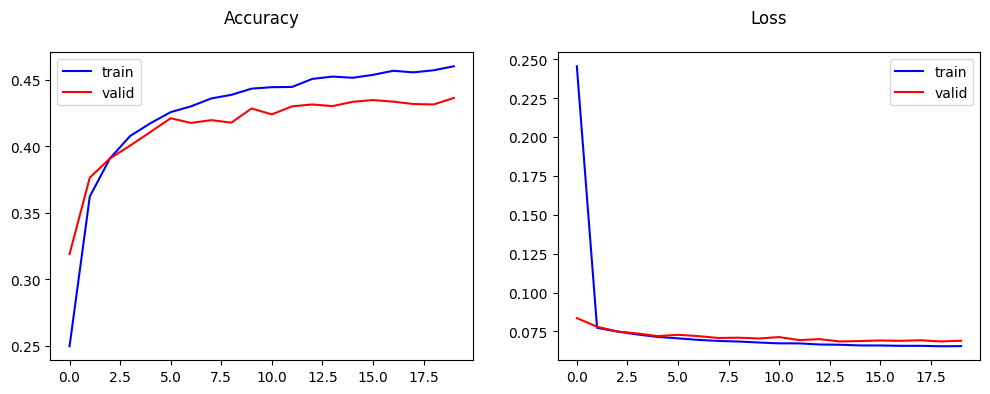

In [52]:
plot_history(history_4, 'accuracy')

Сохранение результатов обучения модели:

In [54]:
save_values(
    'model_4', 
    model=None, 
    params=None, 
    score=round(max(history_4.history['val_accuracy']), 2), 
    mean_time=0.0, 
    save_to=results,
    show_table=False
)

Score: 0.44


Выведение на экран сравнения предсказаний с целевыми значениями:

In [55]:
compare_pred_true(
    X=X_val,
    y=y_val,
    preds=transform_probs_to_labels(model_4.predict(X_val_vect_2))
)

1/1 [==============================] - 0s 104ms/step


,name,prediction,true
0,chilli sauce rice cake,[()],"[(korean,)]"
1,seafood spring onion pancake,[()],"[(korean,)]"
2,ginger lessi smoothie,[()],"[(turkish,)]"
3,bakkwa spring roll,"[(chinese,)]","[(chinese,)]"
4,matcha milk tea large,"[(bubble tea,)]","[(bubble tea,)]"


---

### 2.3 Выбор модели

Выведение на экран таблицы с результатами метрик:

In [58]:
results[['score']].sort_values(by='score', ascending=False)

,score
mlp_class,0.90
model_4,0.44
kn_class,0.41
log_reg,0.23


>**Вывод**
>
>* Лучший показатель был достигнут моделью MLPClassifier.

---

## 3 Тестирование модели

Задание лучшей модели:

In [59]:
best_model = results.loc['mlp_class', 'model']

Получение предсказаний:

In [60]:
preds = best_model.predict(X_test)

Выведение на экран значения метрики на тестовых данных:

In [61]:
print('Score:', round(best_model.score(X_test, y_test), 2))

Score: 0.76


Выведение на экран сравнения предсказаний с целевыми значениями:

In [62]:
compare_pred_true(X_test, y_test, preds)

,name,prediction,true
0,japanese garlic karaage don,"[(ramen,)]","[(ramen,)]"
1,chicken cutlet don,"[(ramen,)]","[(ramen,)]"
2,beef sukiyaki don,"[(japanese, ramen)]","[(ramen,)]"
3,japanese beef yakiniku don,"[(ramen,)]","[(ramen,)]"
4,teriyaki salmon don,"[(japanese, ramen, seafood)]","[(japanese, ramen, seafood)]"


>**Вывод**
>
>* Модель достигла заданного порога точности в 0.6.

---

## 4 Экспорт модели

Задание путей до файлов:

In [101]:
PATH_WEB = 'webapp/model/'

join_path = lambda x: os.path.join(PATH_WEB, x)

path_multilabel = join_path('multilabel.pkl')
path_model = join_path('model.h5')
path_vectorizer = join_path('vectorizer.pkl')

Задание типа модели:

In [102]:
model_type = 'ml'

---

Сохранение и загрузка объекта кодирования:

In [103]:
# save
pickle.dump(multilabel, open(path_multilabel, 'wb'))

# load
multilabel_loaded = pickle.load(open(path_multilabel, 'rb'))

Сохранение и загрузка объекта кодирования:

In [104]:
if model_type == 'dl':
    # save
    best_model.save(path_model)
    # load
    model_loaded = load_model(path_model)
    
else:
    # save
    joblib.dump(best_model, path_model)
    # load
    model_loaded = joblib.load(path_model)

Сохранение векторизатора:

In [105]:
if model_type == 'dl':
    pickle.dump(
        {
            'config': vectorizer_text_tfidf.get_config(),
            'weights': vectorizer_text_tfidf.get_weights()
        },
        open(path_vectorizer, 'wb')
    )
    
    vectorizer_file = pickle.load(open(path_vectorizer, 'rb'))
    
    vectorizer_loaded = layers.TextVectorization.from_config(vectorizer_file['config'])

---

Задание тестового значения:

In [106]:
test_data = 'teriyaki salmon don'

Настройка векторизатора:

In [107]:
if model_type == 'dl':
    vectorizer_loaded.adapt([test_data])
    vectorizer_loaded.set_weights(vectorizer_file['weights'])
    vectorizer_loaded([test_data])

Получение предсказаний:

In [108]:
if model_type == 'dl':
    preds = transform_probs_to_labels(
        model_loaded.predict(
            vectorizer_loaded([test_data])
        )
    )
        
else:
    preds = model_loaded.predict([test_data])

Перевод значений в текст:

In [109]:
transform_label(*preds, multilabel_loaded)

[('japanese', 'ramen', 'seafood')]

>**Вывод**
>
>* Модель и кодировщик со словарём были экспортированы для использования при деплое проекта.

---

## 5 Общий вывод

В ходе построения модели машинного обучения был произведён ряд экспериментов с Baseline и FCNN моделями, среди которых лучше всего продемонстрировали себя последние, поскольку они способны выстраивать более сложные связи при обработке признаков.

В качестве модели для получения предсказаний переданного пользователем наименования блюда была выбрана

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>